# Predicting Heart Disease In Hungary (Group 73)

## Introduction

Heart disease is a broad term that refers to different heart conditions. Something in common is their effect on blood flow and dilation of veins to the heart. Other factors such as age, cholesterol, and blood pressure are also closely linked with heart disease.  

Our aims is whether these factors have a correlation with heart disease, and provide a classification model predicting whether a person has heart disease based on four factors:
1. Age [age]
2. Resting blood pressure (in mm Hg on admission to the hospital) [trestbps]
3. Cholesterol [chol]
4. Maximum heart rate achieved [thalach]

The data was taken from the UCI Machine Learning Repository's Heart Disease Dataset to train our model to predict whether someone has heart disease based on the 4 risk factors listed above. Our model will diagnose heart disease based on the percentage of narrowing in major arteries (<50% meaning no heart disease and >50% meaning heart disease). 

The direcotry is retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. There are four databases: Cleveland, Hungary, Long Beach (California), and Switzerland. The Hungarian data was chosen due to its binary column indicating whether a person is likely to have heart disease. The dataset was collected from the Hungarian Institute of Cardiology in Budapest.

## Data Preparation

Attach libraries.

In [1]:
# Attatch the libraries
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Load the hungarian heart disease dataset and set proper column names.

In [2]:
# load hungarian heart disease dataset from database

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"

hungarian_data <- read_csv(url, col_names = c('age', 'sex', 'chest_pain', 'resting_blood_pressure', 'cholesterol', 
                                              'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                                              'st_depression', 'peak_st_slope', 'major_vessel_num', 'thal', 'diagnosis'))
head(hungarian_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_e...
dbl (5): age, sex, chest_pain, st_depression, diagnosis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,peak_st_slope,major_vessel_num,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


Clean the dataset and select the columns we need for our model.

In [3]:
hungarian_clean <- hungarian_data |>
    # Select applicable columns to use as predictors.
    select(age, resting_blood_pressure, cholesterol, max_heart_rate, diagnosis) |>
    # Change the diagnosis column to factor so that it can be used as the predicted result.
    mutate(diagnosis = as.factor(diagnosis))

# Mutate the data frame so that all of the numerical predictors are doubles rather than characters.             
as_double <- c("resting_blood_pressure", "cholesterol", "max_heart_rate")
hungarian_clean[as_double] <- lapply(hungarian_clean[as_double], as.double)

#Get rid of any rows with NA
hungarian_clean <- hungarian_clean |>
            filter_all(all_vars(!is.na(.)))

# View the cleaned dataframe.
glimpse(hungarian_clean)

Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”
Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”
Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”


Rows: 270
Columns: 5
$ age                    <dbl> 28, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35,…
$ resting_blood_pressure <dbl> 130, 120, 170, 100, 105, 110, 125, 120, 130, 15…
$ cholesterol            <dbl> 132, 243, 237, 219, 198, 225, 254, 298, 161, 21…
$ max_heart_rate         <dbl> 185, 160, 170, 150, 165, 184, 155, 185, 190, 16…
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


Split the cleaned data into a training set and testing set (75% for training and 25% for testing). This proportion was chosen so that there is sufficient training data and testing data and a common convention (Dr. Campbell). 

In [21]:
# Split data into training set and testing set.
set.seed(1000)

hungarian_split <- initial_split(hungarian_clean, prop = 0.75, strata = diagnosis)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

hungarian_train

hungarian_test


age,resting_blood_pressure,cholesterol,max_heart_rate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,132,185,0
30,170,237,170,0
32,105,198,165,0
32,125,254,155,0
33,120,298,185,0
34,150,214,168,0
34,98,220,150,0
35,120,160,185,0
35,150,264,168,0


age,resting_blood_pressure,cholesterol,max_heart_rate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,120,243,160,0
31,100,219,150,0
32,110,225,184,0
34,130,161,190,0
35,140,167,150,0
35,120,308,180,0
37,120,260,130,0
37,130,315,158,0
39,190,241,106,0


Creating an exploratory data analysis table using the training dataset.

In [22]:
hungarian_training_explore <- hungarian_train |>
            group_by(diagnosis)|>
            summarize(n_row = n(),
                      percentage_of_total_data = n()*100/nrow(hungarian_train),
                      age_mean = mean(age),
                      resting_blood_pressure_mean = mean(resting_blood_pressure),
                      cholesterol_mean = mean(cholesterol),
                      max_heart_rate_mean = mean(max_heart_rate))

hungarian_training_explore

diagnosis,n_row,percentage_of_total_data,age_mean,resting_blood_pressure_mean,cholesterol_mean,max_heart_rate_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,126,62.68657,46.77778,129.7619,238.4921,144.6270
1,75,37.31343,49.36000,134.7600,274.4667,129.1867


Visualizing distribution of predictor variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Computation failed in `stat_bin()`:
invalid number of intervals”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Computation failed in `stat_bin()`:
invalid number of intervals”
Warning message:
“Computation failed in `stat_bin()`:
invalid number of intervals”
Warning message:
“Computation failed in `stat_bin()`:
invalid number of intervals”


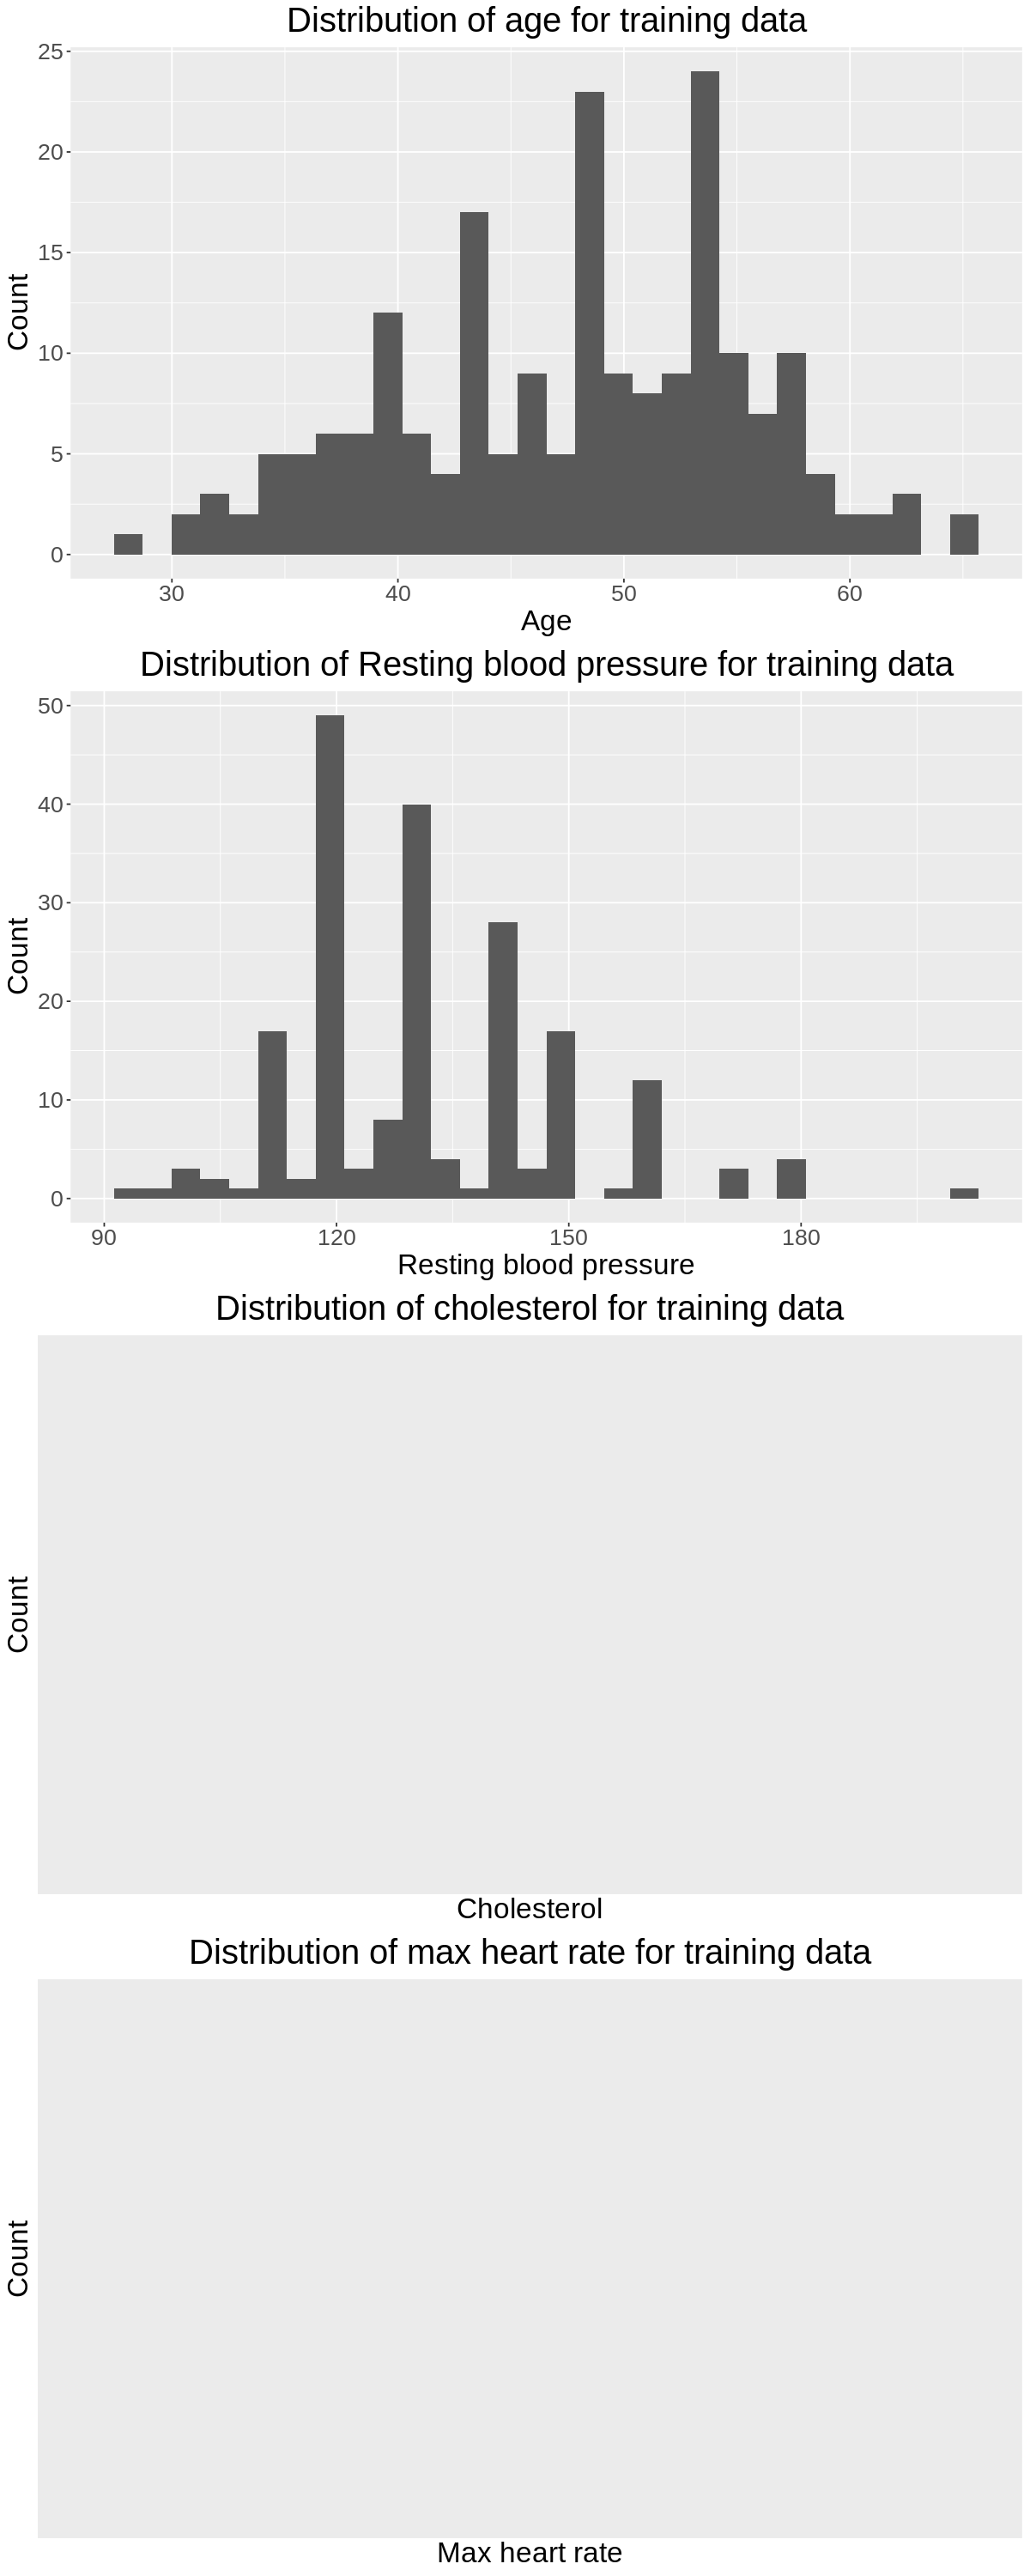

In [23]:
options(repr.plot.width = 10, repr.plot.height = 25)
plot_column <- c('age','resting_blood_pressure', 'cholesterol', 'max_heart_rate')

training_age_plot <- hungarian_train |>
                ggplot(aes(x=age))+
                geom_histogram()+
                labs(x="Age", y="Count")+
                ggtitle("Distribution of age for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5)) +
                geom_histogram(breaks = 30)

training_resting_blood_pressure_plot <- hungarian_train |>
                ggplot(aes(x=resting_blood_pressure))+
                geom_histogram()+
                labs(x="Resting blood pressure", y="Count")+
                ggtitle("Distribution of Resting blood pressure for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5)) +
                geom_histogram(breaks = 30)

training_cholesterol_plot <- hungarian_train |>
                ggplot(aes(x=cholesterol))+
                geom_histogram(breaks = 30)+
                labs(x="Cholesterol", y="Count")+
                ggtitle("Distribution of cholesterol for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_max_heart_rate_plot <- hungarian_train |>
                ggplot(aes(x=max_heart_rate))+
                geom_histogram(breaks = 30)+
                labs(x="Max heart rate", y="Count")+
                ggtitle("Distribution of max heart rate for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5)) 

hungarian_training_plot <- plot_grid(training_age_plot,
                                     training_resting_blood_pressure_plot, 
                                     training_cholesterol_plot, 
                                     training_max_heart_rate_plot,
                                     ncol=1)

hungarian_training_plot

The graphs show a normal distribution of the varibles. 

## Method

We will build the classification model using k-nearest neighbors, the training data (hungarian_train) and test it for accuracy using the testing data (hungarian_test). With cross-validation k number will be chosen, using tune for highest accuracy. The predictor variables will have a numerical data type (not factorable data type), as distance cannot be calculated for factors in k-nearest neighbors.

Then we visualize the tuning using cross-validation, by plotting a graph with number of k vs accuracy. 

## Expected Outcomes and Significance

We expect to find a correlation between our four risk factors and likelihood of having heart disease. Our goal of creating a model with high accuracy of heart disease prediction, if successful, can aid the medical community by creating a fast and easier diagnosis of heart disease, such as in a rural setting where equipment like ECG may not exist. They could input our measurements for each of our 4 risk factors that need minimal equipment and determine whether the patient is developing heart disease. 

Future questions:
- Is our model applicable to other regions such as longbeach?
- Is it ethical to rely only on a model and remove a doctor's role?
- Can a model be 100% accurate?
- Could these data points be used against individuals by insurance companies as a form of stigmatization? How do we protect data but publicize it for others?

## Our Data Anaylysis

In [24]:
hungarian_recipe <- recipe(diagnosis ~ age + resting_blood_pressure + cholesterol + max_heart_rate, data = hungarian_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


hungarian_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In the initialized recipe, we set the diagnosis as our target variable while setting age, resting blood pressure, cholesterol, and max heart rate to be our predictors. The predictors were then standardized(scaled and centered) to have a mean of 0 and a standard deviation of 1.

In [13]:
hungarian_vfold <- vfold_cv(hungarian_train, v = 5, strata = diagnosis)

Doing cross-validation in k-nearest neighbour classification will allow the best k to be picked accordingly to the accuracy that each k results in, where the k that gives the highest prediction accuracy will be chosen. 5-fold cross-validation tunes the model by splitting the overall training data into 5 even-sized groups, in which while 1 group of data is used as the validation set, the other 4 remaining groups are used as the training set. This process was then repeated 5 times (Dr. Campbell).

??? (SOME DESCRIPTION TO BE PUT DOWN)

In [17]:
tibble_made <- tibble(neighbors = seq(1, 30))

tibble_made

neighbors
<int>
1
2
3
4
5
6
7
8
9


In [27]:
results <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = hungarian_vfold, grid = tibble_made) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5126829,5,0.01463592,Preprocessor1_Model01
2,accuracy,binary,0.5126829,5,0.01463592,Preprocessor1_Model02
3,accuracy,binary,0.5175610,5,0.03150935,Preprocessor1_Model03
4,accuracy,binary,0.5175610,5,0.03150935,Preprocessor1_Model04
5,accuracy,binary,0.5425610,5,0.03654897,Preprocessor1_Model05
6,accuracy,binary,0.5425610,5,0.03654897,Preprocessor1_Model06
7,accuracy,binary,0.5873171,5,0.03119866,Preprocessor1_Model07
8,accuracy,binary,0.5873171,5,0.03119866,Preprocessor1_Model08
9,accuracy,binary,0.5773171,5,0.01961994,Preprocessor1_Model09


After combining the recipe and the model specification into a workflow and filtering the workflow to contain only our desired metric variable (accuracy), the estimated accuracy can be observed for each possible k we have previously chosen to test. 

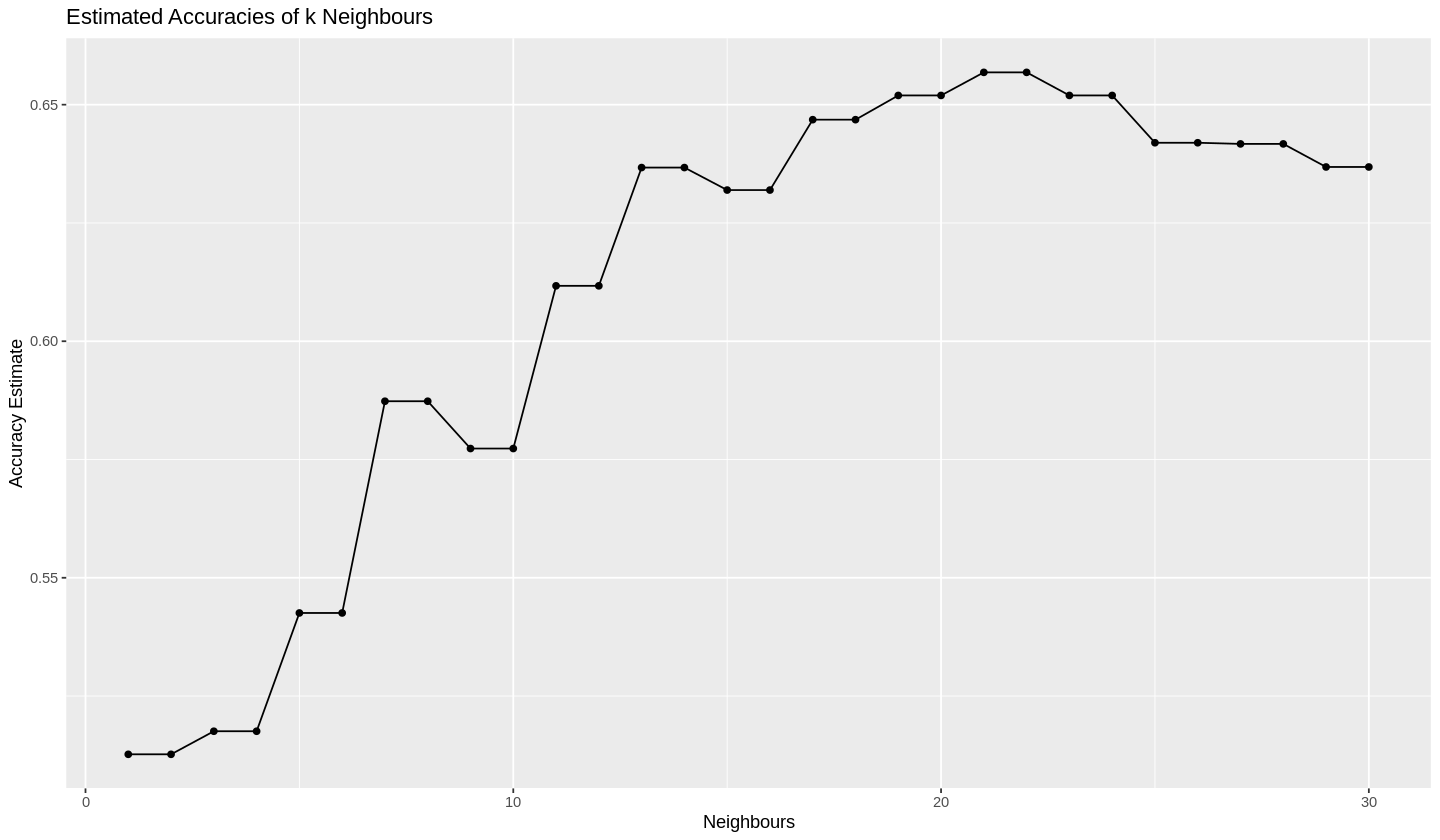

In [20]:
options(repr.plot.width = 12, repr.plot.height = 7)

cross_val_plot <- results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Estimated Accuracies of k Neighbours") 

cross_val_plot

Visualizing the variance of estimated accuracies of the different number of k neighbours, and observed that there is an "elbow" at 21, 22 where the accuracy stops increasing dramatically and begins to level down or start to decrease (Dr. Campbell).

In [21]:
best_k <- results |>
    filter(mean == max(mean)) |>
    pull(neighbors)

best_k

[1] 21 22

In order to get a more accuracy number for k, we filtered the previous workflow that stored the estimated accuracy of each of the picked k to get the k that has the maximum accuracy mean. It is shown to be 21 and 22, where we have picked our k to be 21 as it is already a fairly large k and a higher k might result in overfitting or increase the chance of overfitting. 

In [22]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_best_spec

hungarian_fit <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = hungarian_train)

hungarian_fit

# Get the prediction column
hungarian_predictions <- predict(hungarian_fit, hungarian_test) |> 
    bind_cols(hungarian_test)

# Compare the accuracy of predictions to the true values in the test set
hungarian_accuracy <- hungarian_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

hungarian_accuracy

# Compare the predictions to the true values in a confusion matrix
hungarian_comparison <- hungarian_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

hungarian_comparison

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 21
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.358209
Best kernel: rectangular
Best k: 21

.metric,.estimate
<chr>,<dbl>
accuracy,0.6666667


          Truth
Prediction  0  1
         0 35 15
         1  8 11